# GAN Experiment

Here is my reference for [Pokemon GAN experiment](https://medium.com/@jkleiber8/pokegan-generating-fake-pokemon-with-a-generative-adversarial-network-f540db81548d), which was very helpful for setting up this project.

In [5]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
torch.cuda.is_available()


True

In [6]:
def image_dataset_cleaner(dataset_path):
    """
    Removes images that cannot be read by cv2
    """
    import PIL as pil 
    for image in os.listdir(dataset_path):
        img = cv2.imread(os.path.join(dataset_path, image))
        if image.endswith("csv"):
            print("Found csv file")
            continue
        if img is None:
            print("Removing " + image)
            os.remove(os.path.join(dataset_path, image))
    return 

Trying to open an image from the dark magician train folder.

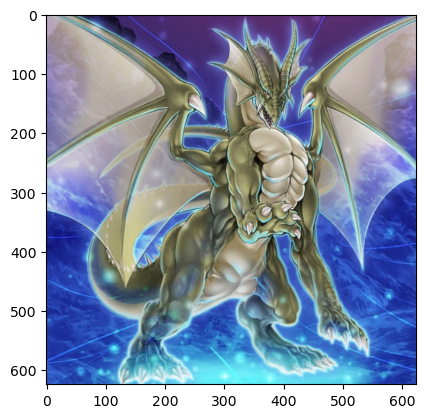

In [7]:
# dataset_path = "training_magician/darkmagician"
dataset_path = "darkmagician_data/train"
image_name = "imgs/3078380.jpg"
img = cv2.imread(os.path.join(dataset_path, image_name))
# show the image
plt.imshow(img)

In [8]:
direct_dataset_path = "darkmagician_data/train/imgs"
print("The dataset before cleaning has " , len(os.listdir(direct_dataset_path)))
image_dataset_cleaner(direct_dataset_path)
print("The dataset after cleaning has " , len(os.listdir(direct_dataset_path)))


The dataset before cleaning has  50
Found csv file
The dataset after cleaning has  50


In [9]:
IMAGE_COUNT = len(os.listdir(direct_dataset_path))
print("The dataset has " , IMAGE_COUNT, " images")

The dataset has  50  images


### Testing my dataset, checking file integrity

In [10]:
import torchvision


In [11]:
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [12]:
IMAGE_DIR = dataset_path
image_size = 64
batch_size = 8
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Convert channels from [0, 1] to [-1, 1]

In [13]:
normal_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Augment the dataset with mirrored images
mirror_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomHorizontalFlip(p=1.0),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Augment the dataset with color changes
color_jitter_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ColorJitter(0.5, 0.5, 0.5),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Combine the datasets
dataset_list = [normal_dataset, mirror_dataset, color_jitter_dataset]

AUGMENTATION_RANGE = 0
dataset_list_full = []
for i in range(AUGMENTATION_RANGE):
    # normal_dataset
    dataset_list_full += dataset_list
    # dataset_list_full += [normal_dataset]

if len(dataset_list_full)==0:
    dataset_list_full = dataset_list

dataset = ConcatDataset(dataset_list_full)

dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=False)

if AUGMENTATION_RANGE != 0:
    print("The estimated number of images is ", IMAGE_COUNT * AUGMENTATION_RANGE * 3)
else:
    print("The estimated number of images is ", IMAGE_COUNT * 1 * 3)




The estimated number of images is  150


Since these images have been normalized to [-1, 1],  we need to denormalize them in order to view them. Below is a denormalization function to do just that.

In [14]:
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]

Now let's show a sample batch of real Pokemon images

In [15]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=64):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

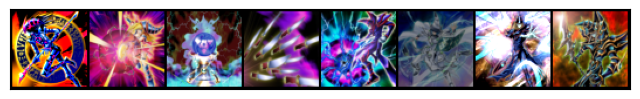

In [17]:
show_batch(dataloader)

Now that we know the visualization works, we can continue with making the GAN. First, we'll start with the discriminator

# Discriminator Models

Below I make a few possible discriminator models to try out

In [18]:
import torch.nn as nn

This is my first effort at making a discriminator for this dataset

In [19]:
disc_1 = nn.Sequential(
    # Input is 3 x 256 x 256
    nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 16 x 128 x 128
    
    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 32 x 64 x 64
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 512 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [20]:
disc_2 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
disc_2.fc.out_features = 1
disc_2

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.6.0
/opt/conda/envs/gx/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/gx/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
# Same as Discriminator 1, but with smaller kernel size
disc_3 = nn.Sequential(
    # Input is 3 x 256 x 256
    nn.Conv2d(3, 16, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 16 x 128 x 128
    
    nn.Conv2d(16, 32, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 32 x 64 x 64
    
    nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 512 x 4 x 4
    
    # Additional layer to make it 2x2
    nn.Conv2d(512, 1024, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 512 x 2 x 2
    
    # With a 2x2, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(1024, 1, kernel_size=2, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [22]:
disc_5 = nn.Sequential(
    # Input is 3 x 256 x 256
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 64 x 128 x 128
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 128 x 64 x 64
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 32 x 32
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 16 x 16
    
    nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 8 x 8
    
    nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [23]:
disc_64_1 = nn.Sequential(
    # Input is 3 x 64 x 64
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 32 x 32 x 32
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 64 x 16 x 16
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 8 x 8
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 256 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [24]:
disc_64_2 = nn.Sequential(
    # Input is 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 8 x 8
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

# Generator Models

Below is a list of some possible generator models to try. These models are inverse operations of the discriminators.

Here's the first generator:

In [25]:
seed_size = 16

In [26]:
gen_1 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 512, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Layer output: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 32 x 64 x 64
    
    nn.ConvTranspose2d(32, 16, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # Layer output: 16 x 128 x 128
    
    nn.ConvTranspose2d(16, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [27]:
# Generator matching Discriminator 3
gen_3 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 1024, kernel_size=2, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # Layer output: 1024 x 2 x 2
    
    nn.ConvTranspose2d(1024, 512, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Layer output: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 32, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 32 x 64 x 64
    
    nn.ConvTranspose2d(32, 16, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # Layer output: 16 x 128 x 128
    
    nn.ConvTranspose2d(16, 3, kernel_size=2, padding=0, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [28]:
# Generator with lots of upsampling weirdness
gen_4 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 1024, kernel_size=2, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # Layer output: 1024 x 2 x 2
    
    nn.ConvTranspose2d(1024, 512, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Layer output: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1, stride=9, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 64 x 64
    
    nn.ConvTranspose2d(128, 3, kernel_size=4, padding=0, stride=4, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [29]:
gen_5 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 256, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(256, 256, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 256, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 16 x 16
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 32 x 32
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 128 x 64 x 64
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 64 x 128 x 128
    
    nn.ConvTranspose2d(32, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [30]:
gen_64_1 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 256, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 8 x 8
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 64 x 16 x 16
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 32 x 32 x 32
    
    nn.ConvTranspose2d(32, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 64 x 64
)

In [31]:
gen_64_2 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 128, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 8 x 8
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 64 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 32 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 64 x 64
)

# Model Testing

This is to make sure everything is the correct size

In [32]:
test_model_size = False

if test_model_size:
    # Make some latent tensors to seed the generator
    seed_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)

    # Get some fake pokemon
    generator=gen_64_1
    to_device(generator, device)
    fake_pokemon = generator(seed_batch)
    print(fake_pokemon.size())

# GPU Setup
We should train this on a GPU, so I'll set that up right now

In [33]:
def get_training_device():
    # Use the GPU if possible
    if torch.cuda.is_available():
        return torch.device('cuda')
    # Otherwise use the CPU :-(
    return torch.device('cpu')

def to_device(data, device):
    # This moves the tensors to the device (GPU, CPU)
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [34]:
device = get_training_device()
device

device(type='cuda')

If the above output doesn't say something about 'cuda', then make sure the notebook is set up to run on the GPU accelerator.  

Now, we use the device dataloader class to send data to our chosen device:

In [35]:
# Using the dataloader from the top of the notebook, and the selected device
# create a device data loader
dev_dataloader = DeviceDataLoader(dataloader, device)

# **Training Functions**

## Discriminator

In [36]:
def train_discriminator(real_pokemon, disc_optimizer):
    # Reset the gradients for the optimizer
    disc_optimizer.zero_grad()
    
    # Train on the real images
    real_predictions = discriminator(real_pokemon)
    # real_targets = torch.zeros(real_pokemon.size(0), 1, device=device) # All of these are real, so the target is 0.
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0 # Add some noisy labels to make the discriminator think harder.
    real_loss = F.binary_cross_entropy(real_predictions, real_targets) # Can do binary loss function because it is a binary classifier
    real_score = torch.mean(real_predictions).item() # How well does the discriminator classify the real pokemon? (Higher score is better for the discriminator)
    
    # Make some latent tensors to seed the generator
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    
    # Get some fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Train on the generator's current efforts to trick the discriminator
    gen_predictions = discriminator(fake_pokemon)
    # gen_targets = torch.ones(fake_pokemon.size(0), 1, device=device)
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9 # Add some noisy labels to make the discriminator think harder.
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score = torch.mean(gen_predictions).item() # How well did the discriminator classify the fake pokemon? (Lower score is better for the discriminator)
    
    # Update the discriminator weights
    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()
    return total_loss.item(), real_score, gen_score

## Generator

In [37]:
def train_generator(gen_optimizer):
    # Clear the generator gradients
    gen_optimizer.zero_grad()
    
    # Generate some fake pokemon
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)
    
    # Test against the discriminator
    disc_predictions = discriminator(fake_pokemon)
    targets = torch.zeros(fake_pokemon.size(0), 1, device=device) # We want the discriminator to think these images are real.
    loss = F.binary_cross_entropy(disc_predictions, targets) # How well did the generator do? (How much did the discriminator believe the generator?)
    
    # Update the generator based on how well it fooled the discriminator
    loss.backward()
    gen_optimizer.step()
    
    # Return generator loss
    return loss.item()

## Results Viewer
We want to be able to see the results as we generate pokemon

In [38]:
import os
from torchvision.utils import save_image

RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

In [39]:
def save_results(index, latent_batch, show=True):
    # Generate fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Make the filename for the output
    fake_file = "result-image-{0:0=4d}.png".format(index)
    
    # Save the image
    save_image(denorm(fake_pokemon), os.path.join(RESULTS_DIR, fake_file), nrow=8)
    print("Result Saved!")
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))

In [40]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
torch.cuda.is_available()


True

# **Full Training**

In [41]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Static generation seed batch
fixed_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
    # Empty the GPU cache to save some memory
    torch.cuda.empty_cache()
    
    # Track losses and scores
    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []
    
    # Create the optimizers
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    # Run the loop
    for epoch in range(epochs):
        # Go through each image
        for real_img, _ in tqdm(dev_dataloader):
            # Train the discriminator
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)

            # Train the generator
            gen_loss = train_generator(gen_optimizer)
        
        # Collect results
        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)
        
        # Print the losses and scores
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch+start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        
        # Save the images and show the progress
        save_results(epoch + start_idx, fixed_latent_batch, show=False)
    
    # Return stats
    return disc_losses, disc_scores, gen_losses, gen_scores

# GPU Clean-up
Sometimes the Kaggle GPU runs out of memory. This block frees up the GPU and resends the device dataloader to the GPU

In [42]:
device = get_training_device()
device

device(type='cuda')

In [43]:
def debug_memory():
    import collections, gc, resource, torch
    print('maxrss = {}'.format(
        resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))
    tensors = collections.Counter((str(o.device), o.dtype, tuple(o.shape))
                                  for o in gc.get_objects()
                                  if torch.is_tensor(o))
    for line in tensors.items():
        print('{}\t{}'.format(*line))

In [44]:
mem_debug = False
if mem_debug:
    debug_memory()

In [45]:
# Clean up everything
cleanup = False
if cleanup:
    import gc
    del dev_dataloader
    del discriminator
    del generator
    dev_dataloader = None
    discriminator = None
    generator = None
    gc.collect()
    torch.cuda.empty_cache()

In [46]:
# Re-initialize the device dataloader
dev_dataloader = DeviceDataLoader(dataloader, device)

# Selecting Models
Here, I select the models I want to send to the GPU

In [47]:
# Discriminators
# discriminator = disc_1
# discriminator = disc_2
# discriminator = disc_3
# discriminator = disc_5

# 64 x 64 Discriminators
# discriminator = disc_64_1
discriminator = disc_64_2

# Send to device
discriminator = to_device(discriminator, device)

In [48]:
# Generators
# generator = gen_1
# generator = gen_3
# generator = gen_5

# 64 x 64 Generators
# generator = gen_64_1
generator = gen_64_2

# Send to device
generator = to_device(generator, device)

# Training Time
Here I'll edit hyperparameters and train the GAN

In [49]:
# learning_rate = 0.0025 # worked fairly well for disc/gen_64_1
learning_rate = 0.00275
epochs = 100

In [50]:
history = train(epochs, learning_rate)

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [1/100], gen_loss: 3.0352, disc_loss: 0.9739, real_score: 0.0341, gen_score: 0.5143
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [2/100], gen_loss: 4.1092, disc_loss: 0.6567, real_score: 0.0271, gen_score: 0.6724
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [3/100], gen_loss: 4.9314, disc_loss: 1.1567, real_score: 0.5194, gen_score: 0.9914
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [4/100], gen_loss: 3.6671, disc_loss: 0.5791, real_score: 0.1093, gen_score: 0.8767
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [5/100], gen_loss: 4.0828, disc_loss: 4.4380, real_score: 0.0036, gen_score: 0.0205
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [6/100], gen_loss: 3.8949, disc_loss: 4.2365, real_score: 0.3309, gen_score: 0.0432
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [7/100], gen_loss: 2.7794, disc_loss: 1.5589, real_score: 0.5530, gen_score: 0.6549
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [8/100], gen_loss: 1.9194, disc_loss: 1.2576, real_score: 0.4603, gen_score: 0.8298
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [9/100], gen_loss: 3.5822, disc_loss: 1.1106, real_score: 0.4905, gen_score: 0.9863
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [10/100], gen_loss: 3.1490, disc_loss: 0.4949, real_score: 0.0809, gen_score: 0.8921
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [11/100], gen_loss: 3.5973, disc_loss: 1.2085, real_score: 0.4614, gen_score: 0.6893
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [12/100], gen_loss: 3.1567, disc_loss: 0.6508, real_score: 0.0734, gen_score: 0.7075
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [13/100], gen_loss: 3.7417, disc_loss: 1.1287, real_score: 0.4697, gen_score: 0.8887
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [14/100], gen_loss: 4.1113, disc_loss: 0.7149, real_score: 0.3322, gen_score: 0.9701
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [15/100], gen_loss: 4.3144, disc_loss: 2.1691, real_score: 0.0434, gen_score: 0.1533
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [16/100], gen_loss: 5.2908, disc_loss: 1.5291, real_score: 0.3915, gen_score: 0.5742
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [17/100], gen_loss: 3.4936, disc_loss: 0.6545, real_score: 0.2919, gen_score: 0.9139
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [18/100], gen_loss: 5.8791, disc_loss: 0.8392, real_score: 0.0287, gen_score: 0.5158
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [19/100], gen_loss: 3.4354, disc_loss: 0.6940, real_score: 0.1563, gen_score: 0.7836
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [20/100], gen_loss: 4.6348, disc_loss: 0.7754, real_score: 0.1261, gen_score: 0.6097
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [21/100], gen_loss: 3.6259, disc_loss: 0.5035, real_score: 0.2150, gen_score: 0.9836
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [22/100], gen_loss: 2.4513, disc_loss: 0.8007, real_score: 0.2749, gen_score: 0.7395
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [23/100], gen_loss: 0.2616, disc_loss: 1.4849, real_score: 0.5967, gen_score: 0.8170
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [24/100], gen_loss: 2.8395, disc_loss: 0.6730, real_score: 0.2833, gen_score: 0.8363
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [25/100], gen_loss: 2.2785, disc_loss: 1.0537, real_score: 0.4471, gen_score: 0.8037
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [26/100], gen_loss: 3.6843, disc_loss: 0.5546, real_score: 0.1883, gen_score: 0.8411
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [27/100], gen_loss: 3.6991, disc_loss: 1.1335, real_score: 0.1403, gen_score: 0.4452
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [28/100], gen_loss: 2.1602, disc_loss: 1.6011, real_score: 0.3600, gen_score: 0.3973
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [29/100], gen_loss: 1.9558, disc_loss: 1.6143, real_score: 0.6999, gen_score: 0.7831
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [30/100], gen_loss: 2.5476, disc_loss: 2.4013, real_score: 0.8789, gen_score: 0.9507
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [31/100], gen_loss: 3.6287, disc_loss: 0.5939, real_score: 0.1534, gen_score: 0.8120
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [32/100], gen_loss: 5.7094, disc_loss: 1.1839, real_score: 0.0519, gen_score: 0.5242
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [33/100], gen_loss: 2.4988, disc_loss: 0.6797, real_score: 0.3038, gen_score: 0.8670
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [34/100], gen_loss: 3.1263, disc_loss: 0.8723, real_score: 0.0805, gen_score: 0.5408
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [35/100], gen_loss: 2.6400, disc_loss: 0.9407, real_score: 0.5106, gen_score: 0.9188
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [36/100], gen_loss: 2.4001, disc_loss: 0.8909, real_score: 0.3766, gen_score: 0.8438
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [37/100], gen_loss: 4.5585, disc_loss: 0.4721, real_score: 0.1698, gen_score: 0.9614
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [38/100], gen_loss: 2.7380, disc_loss: 0.4864, real_score: 0.1849, gen_score: 0.8635
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [39/100], gen_loss: 3.7243, disc_loss: 1.1596, real_score: 0.3517, gen_score: 0.6342
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [40/100], gen_loss: 3.5539, disc_loss: 1.0784, real_score: 0.1745, gen_score: 0.5406
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [41/100], gen_loss: 4.0470, disc_loss: 0.6731, real_score: 0.1981, gen_score: 0.7398
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [42/100], gen_loss: 4.3170, disc_loss: 0.3965, real_score: 0.0981, gen_score: 0.8451
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [43/100], gen_loss: 5.3425, disc_loss: 0.7180, real_score: 0.0651, gen_score: 0.7497
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [44/100], gen_loss: 0.8139, disc_loss: 1.3752, real_score: 0.5862, gen_score: 0.6736
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [45/100], gen_loss: 2.5405, disc_loss: 0.9273, real_score: 0.3934, gen_score: 0.8847
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [46/100], gen_loss: 4.7382, disc_loss: 0.8551, real_score: 0.0808, gen_score: 0.5978
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [47/100], gen_loss: 5.4984, disc_loss: 0.6494, real_score: 0.1219, gen_score: 0.9695
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [48/100], gen_loss: 3.5037, disc_loss: 0.6185, real_score: 0.1053, gen_score: 0.7350
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [49/100], gen_loss: 3.5148, disc_loss: 0.8357, real_score: 0.3901, gen_score: 0.8990
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [50/100], gen_loss: 2.9524, disc_loss: 0.6187, real_score: 0.0203, gen_score: 0.8870
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [51/100], gen_loss: 1.3557, disc_loss: 1.5744, real_score: 0.6923, gen_score: 0.8097
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [52/100], gen_loss: 4.2632, disc_loss: 0.8958, real_score: 0.1681, gen_score: 0.7851
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [53/100], gen_loss: 3.7953, disc_loss: 0.4038, real_score: 0.1150, gen_score: 0.9280
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [54/100], gen_loss: 3.5894, disc_loss: 0.7209, real_score: 0.3339, gen_score: 0.9283
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [55/100], gen_loss: 3.8378, disc_loss: 0.7723, real_score: 0.2647, gen_score: 0.7182
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [56/100], gen_loss: 3.3442, disc_loss: 0.8913, real_score: 0.3216, gen_score: 0.8679
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [57/100], gen_loss: 7.1186, disc_loss: 2.0052, real_score: 0.1189, gen_score: 0.2460
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [58/100], gen_loss: 3.8373, disc_loss: 0.8078, real_score: 0.2003, gen_score: 0.6372
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [59/100], gen_loss: 5.1259, disc_loss: 0.6383, real_score: 0.1126, gen_score: 0.8234
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [60/100], gen_loss: 3.5754, disc_loss: 0.5762, real_score: 0.1170, gen_score: 0.9146
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [61/100], gen_loss: 6.6429, disc_loss: 0.5711, real_score: 0.0301, gen_score: 0.8803
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [62/100], gen_loss: 4.0118, disc_loss: 0.4134, real_score: 0.0620, gen_score: 0.8743
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [63/100], gen_loss: 2.0462, disc_loss: 1.1952, real_score: 0.3151, gen_score: 0.7165
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [64/100], gen_loss: 5.6482, disc_loss: 1.2622, real_score: 0.0583, gen_score: 0.5351
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [65/100], gen_loss: 3.4679, disc_loss: 0.6814, real_score: 0.2255, gen_score: 0.7594
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [66/100], gen_loss: 3.8946, disc_loss: 1.8189, real_score: 0.0855, gen_score: 0.2788
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [67/100], gen_loss: 5.5809, disc_loss: 0.8226, real_score: 0.2052, gen_score: 0.7519
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [68/100], gen_loss: 3.5061, disc_loss: 0.4644, real_score: 0.1539, gen_score: 0.9242
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [69/100], gen_loss: 4.7831, disc_loss: 0.9114, real_score: 0.4335, gen_score: 0.8949
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [70/100], gen_loss: 2.0203, disc_loss: 1.4812, real_score: 0.3675, gen_score: 0.9055
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [71/100], gen_loss: 3.6164, disc_loss: 1.4014, real_score: 0.6455, gen_score: 0.8839
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [72/100], gen_loss: 3.1294, disc_loss: 1.0495, real_score: 0.3062, gen_score: 0.7530
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [73/100], gen_loss: 4.1733, disc_loss: 0.8889, real_score: 0.1206, gen_score: 0.6812
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [74/100], gen_loss: 7.0288, disc_loss: 1.4137, real_score: 0.0144, gen_score: 0.4712
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [75/100], gen_loss: 2.9435, disc_loss: 0.5712, real_score: 0.0765, gen_score: 0.7443
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [76/100], gen_loss: 5.7060, disc_loss: 0.5891, real_score: 0.2117, gen_score: 0.9202
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [77/100], gen_loss: 4.6370, disc_loss: 0.9377, real_score: 0.0945, gen_score: 0.5712
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [78/100], gen_loss: 6.1491, disc_loss: 0.7742, real_score: 0.0158, gen_score: 0.7168
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [79/100], gen_loss: 3.2602, disc_loss: 2.2060, real_score: 0.3689, gen_score: 0.7417
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [80/100], gen_loss: 6.0110, disc_loss: 0.7400, real_score: 0.1793, gen_score: 0.7055
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [81/100], gen_loss: 3.7269, disc_loss: 0.5705, real_score: 0.0351, gen_score: 0.7375
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [82/100], gen_loss: 4.1748, disc_loss: 0.5900, real_score: 0.0864, gen_score: 0.8442
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [83/100], gen_loss: 5.1589, disc_loss: 0.4192, real_score: 0.0455, gen_score: 0.8137
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [84/100], gen_loss: 2.7795, disc_loss: 0.4318, real_score: 0.0518, gen_score: 0.8684
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [85/100], gen_loss: 5.6266, disc_loss: 0.5230, real_score: 0.1008, gen_score: 0.8016
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [86/100], gen_loss: 6.7601, disc_loss: 0.5965, real_score: 0.1102, gen_score: 0.8679
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [87/100], gen_loss: 5.7724, disc_loss: 1.6930, real_score: 0.0561, gen_score: 0.3517
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [88/100], gen_loss: 5.2991, disc_loss: 0.6316, real_score: 0.1436, gen_score: 0.7728
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [89/100], gen_loss: 4.9086, disc_loss: 0.4269, real_score: 0.0201, gen_score: 0.9221
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [90/100], gen_loss: 5.4938, disc_loss: 0.7279, real_score: 0.3329, gen_score: 0.9129
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [91/100], gen_loss: 3.8852, disc_loss: 1.3837, real_score: 0.3575, gen_score: 0.7945
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [92/100], gen_loss: 4.9509, disc_loss: 0.5874, real_score: 0.0215, gen_score: 0.8197
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [93/100], gen_loss: 5.3152, disc_loss: 1.5306, real_score: 0.5810, gen_score: 0.9931
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [94/100], gen_loss: 3.2974, disc_loss: 1.1186, real_score: 0.4545, gen_score: 0.7547
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [95/100], gen_loss: 5.6692, disc_loss: 0.6716, real_score: 0.0381, gen_score: 0.7717
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [96/100], gen_loss: 4.4760, disc_loss: 0.5675, real_score: 0.0540, gen_score: 0.8668
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [97/100], gen_loss: 5.2709, disc_loss: 0.7939, real_score: 0.1226, gen_score: 0.6870
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [98/100], gen_loss: 4.1563, disc_loss: 0.9273, real_score: 0.4090, gen_score: 0.9594
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [99/100], gen_loss: 5.0141, disc_loss: 0.6634, real_score: 0.0530, gen_score: 0.9828
Result Saved!


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [100/100], gen_loss: 6.2071, disc_loss: 0.5990, real_score: 0.0434, gen_score: 0.7691
Result Saved!


# View Results
Here, we will view the results for the PokeGAN using IPython's Image class

In [51]:
from IPython.display import Image

There are some blobs appearing at 10 epochs

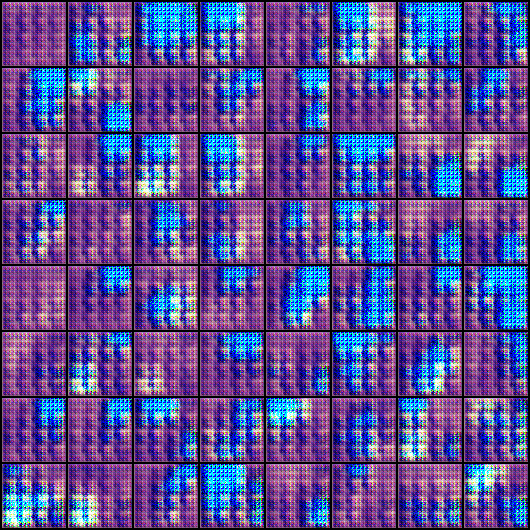

In [52]:
Image('./results/result-image-0010.png')

At 25 epochs the fake pokemon have more defined shapes:

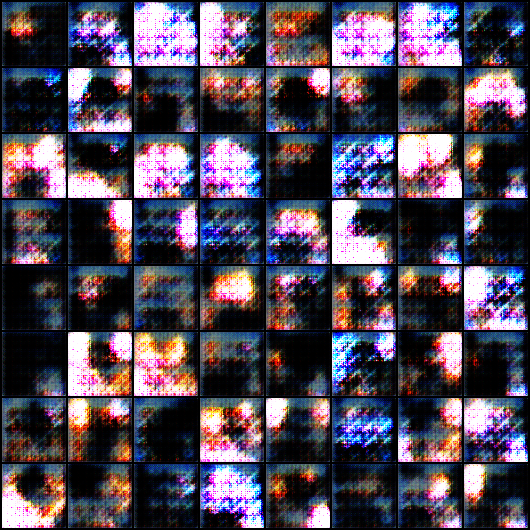

In [53]:
Image('./results/result-image-0025.png')

And by 50 epochs, more distinct features start appearing:

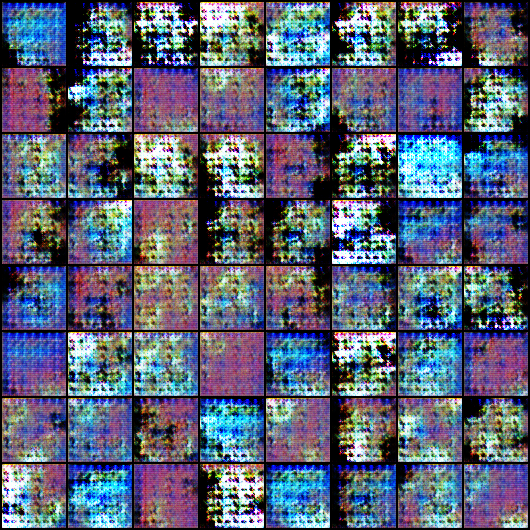

In [54]:
Image('./results/result-image-0050.png')

# Performance Analysis

Here are some plots to help tune the generator/discriminator. This shows losses and scores over time.

In [55]:
# Extract metrics
disc_losses, disc_scores, gen_losses, gen_scores = history

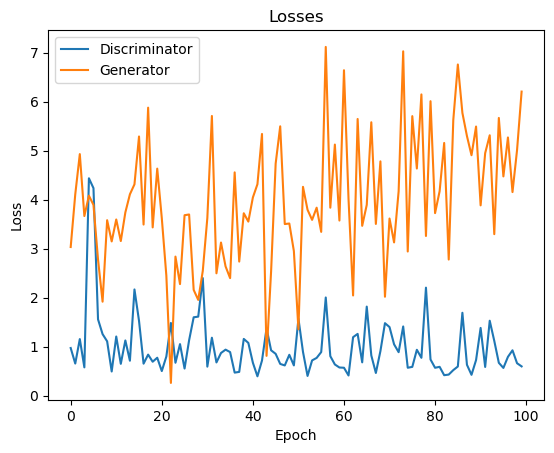

In [56]:
# Plot generator and discriminator losses
plt.plot(disc_losses, '-')
plt.plot(gen_losses, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

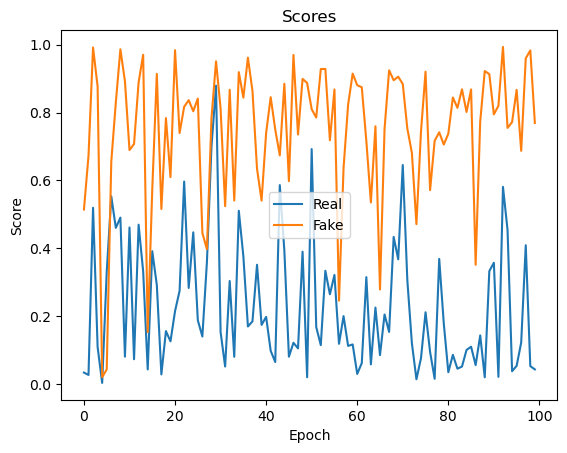

In [57]:
# Plots scores vs. epochs
plt.plot(disc_scores, '-')
plt.plot(gen_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

# Exporting Data
If the model works well, it definitely should be saved for later! Here I will export the weights for both the discriminator and generator, as well as send the notebook to Jovian.ml

In [58]:
# Save generator and discriminator weights
torch.save(discriminator.state_dict(), 'discriminator-model.pth')
torch.save(generator.state_dict(), 'generator-model.pth')

In [59]:
# example of calculating the frechet inception distance in Keras
import numpy
import os
os.environ["KERAS_BACKEND"] = "torch"
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
images1 = randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
FID (same): -0.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
FID (different): 43.155


In [60]:
my_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

fake_ygo = generator(my_latent_batch)
index = 100
# Make the filename for the output
fake_file = "MY___result-image-{0:0=4d}.png".format(index)

# Save the image
save_image(denorm(fake_ygo), os.path.join(RESULTS_DIR, fake_file), nrow=8)

In [61]:
len(fake_ygo)

64

In [62]:
case_study = fake_ygo[0]
my_fake = "my_fake_image_01.png"
save_image(denorm(case_study), os.path.join(RESULTS_DIR, my_fake))

In [63]:
case_study

tensor([[[-0.4781, -0.5240, -0.6693,  ..., -0.5297, -0.4682, -0.3357],
         [-0.7189, -0.7725, -0.6502,  ..., -0.5079, -0.5754, -0.3654],
         [-0.6539, -0.6166, -0.5443,  ..., -0.7213, -0.5839, -0.3419],
         ...,
         [-0.6615, -0.7409, -0.7348,  ..., -0.1764,  0.1984, -0.0732],
         [-0.4402, -0.4763, -0.5198,  ...,  0.2247,  0.2411,  0.2176],
         [-0.3379, -0.4973, -0.5435,  ...,  0.2689,  0.1554,  0.0344]],

        [[-0.4212, -0.3641, -0.5227,  ..., -0.3028, -0.3450, -0.3837],
         [-0.6761, -0.6125, -0.4699,  ..., -0.3208, -0.3139, -0.2302],
         [-0.6818, -0.6075, -0.4213,  ..., -0.6092, -0.7023, -0.2403],
         ...,
         [-0.7693, -0.7867, -0.7382,  ..., -0.6105, -0.6657, -0.7325],
         [-0.5482, -0.4940, -0.6519,  ..., -0.3631, -0.6278, -0.6412],
         [-0.3996, -0.5838, -0.5868,  ..., -0.2906, -0.4404, -0.3352]],

        [[-0.1841, -0.1920, -0.2438,  ...,  0.1059,  0.0065, -0.1418],
         [-0.3334, -0.4274, -0.0767,  ..., -0

In [64]:
case_study.cpu().detach().numpy()

array([[[-0.47810027, -0.5239507 , -0.66929334, ..., -0.52972007,
         -0.46824354, -0.33567688],
        [-0.7189178 , -0.77254045, -0.65022   , ..., -0.50789213,
         -0.5754198 , -0.3653601 ],
        [-0.65387464, -0.6165736 , -0.5442519 , ..., -0.72130585,
         -0.58387595, -0.34187606],
        ...,
        [-0.6614634 , -0.74087834, -0.7347976 , ..., -0.17637812,
          0.19835085, -0.07319488],
        [-0.44020745, -0.47628576, -0.51979667, ...,  0.22468677,
          0.2411251 ,  0.21762285],
        [-0.33786625, -0.49733666, -0.54350156, ...,  0.26889455,
          0.15537673,  0.03435747]],

       [[-0.4211974 , -0.36411998, -0.52268517, ..., -0.30275518,
         -0.34503764, -0.3836831 ],
        [-0.6760968 , -0.6125174 , -0.46986938, ..., -0.32084134,
         -0.3138732 , -0.23021801],
        [-0.6818066 , -0.60753334, -0.4213048 , ..., -0.609159  ,
         -0.7022604 , -0.24029298],
        ...,
        [-0.7692549 , -0.78670484, -0.73815185, ..., -

In [65]:
case_study.cpu().detach().numpy().shape


(3, 64, 64)

In [66]:
import PIL.Image as Image

In [67]:
fake_image = Image.open("results/my_fake_image_01.png")

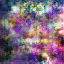

In [68]:
fake_image

In [69]:
real_image = Image.open("training_magician/darkmagician/23020408.jpg")
real_image = real_image.resize((64,64))

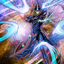

In [70]:
real_image

In [71]:
fake_array = numpy.array(fake_image)
real_array = numpy.array(real_image)

In [72]:
fake_array.shape == real_array.shape

True

In [73]:
lfake = numpy.array([fake_array, fake_array*0.5])
lreal = numpy.array([real_array, real_array*0.5])

In [74]:
images1 = lfake
images2= lreal
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

Scaled (2, 299, 299, 3) (2, 299, 299, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
FID (same): -0.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
FID (different): 514.368


In [75]:
# example of calculating the frechet inception distance in Keras
import numpy
import os
os.environ["KERAS_BACKEND"] = "torch"
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
images1 = randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
FID (same): -0.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
FID (different): 37.897


In [76]:
import torch
import torchvision
import ignite

print(*map(lambda m: ": ".join((m.__name__, m.__version__)), (torch, torchvision, ignite)), sep="\n")


ModuleNotFoundError: No module named 'ignite'

In [ ]:
import os
import logging
import matplotlib.pyplot as plt

import numpy as np

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist


In [ ]:
ignite.utils.manual_seed(999)


In [ ]:
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)


<Logger ignite.distributed.launcher.Parallel (WARNING)>

In [ ]:
from ignite.metrics import FID, InceptionScore

In [ ]:
import ignite.distributed as idist

In [ ]:
fid_metric = FID(device=idist.device())


In [ ]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
torch.cuda.is_available()


True

In [ ]:
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

# Acknowledgements

This wouldn't be possible without some good resources:

- Jovian.ml DCGAN example from PyTorch Zero to GANs Course: https://jovian.ml/aakashns/06b-anime-dcgan
- Tips and tricks about training GANs: https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9